# Flights Price Analysis 

The goal of this notebook is to run some analysis on a dataset that contains one-way flights found on Expedia between 2022-04-16 and 2022-10-05 (you can find it at this [link](https://www.kaggle.com/datasets/dilwong/flightprices)).

In [1]:
%%configure -f
{"executorMemory":"8G", "numExecutors":2, "executorCores":3, "conf": {"spark.dynamicAllocation.enabled": "false"}}

In [2]:
val bucketname = "unibo-bd2223-vfolin"

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
3,application_1678803017301_0004,spark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

bucketname: String = unibo-bd2223-vfolin


## Data Preparation

The following columns will be kept and created:
- flightID: Identifier for the flight.
- searchDate: Date the record was obtained from Expedia.
- searchMonth: Month the record was obtained from Expedia.
- searchDay: Day the record was obtained from Expedia.
- flightDate: The date of the flight.
- flightMonth: The month of the flight.
- flightDay: The day of the flight.
- startingAirport: 3-letter code for the starting airport.
- destinationAirport: 3-letter code for the destination airport.
- duration: Travel duration in minutes.
- isEconomy: Is basic economy?
- isRefundable: Is the ticket refundable?
- isNonStop: Is the flight non-stop?
- baseFare: Price of the ticket (not including taxes).
- totalFare: Price of the ticket, including taxes and fees.
- seatsRemaining: Number of remaining seats.
- travelDistance: The total travel distance in miles.

In [3]:
case class FlightData(
    flightID:String,
    searchDate:String,
    searchMonth:String,
    searchDay:String,
    flightDate:String,
    flightMonth:String,
    flightDay:String,
    startingAirport:String,
    destinationAirport:String,
    duration:Int,
    isEconomy:Boolean,
    isRefundable:Boolean,
    isNonStop:Boolean,
    baseFare:Double,
    totalFare:Double,
    seatsRemaining:Int,
    travelDistance:Int
)

object FlightData {

    def parse(line:String) = {
        val input = line.split(",")
        val flightID = input(0)
        val searchDate = input(1)
        val searchMonth = searchDate.substring(5,7)
        val searchDay = searchDate.substring(8,10)
        val flightDate = input(2)
        val flightMonth = flightDate.substring(5,7)
        val flightDay = flightDate.substring(8,10)
        val startingAirport = input(3)
        val destinationAirport = input(4)
        val dur = input(6).replace("P","").replace("T","").split("D|H|M").map(x => x.toInt)
        val duration = dur.length match {
            case 3 => dur(0) * 1440 + dur(1) * 60 + dur(2)
            case 2 => dur(0) * 60 + dur(1)
            case 1 => dur(0)
        }
        val isEconomy = input(8).toBoolean
        val isRefundable = input(9).toBoolean
        val isNonStop = input(10).toBoolean
        val baseFare = input(11).toDouble
        val totalFare = input(12).toDouble
        val seatsRemaining = input(13).toInt
        val travelDistance = input(14) match {
            case "" => 0
            case _ => input(14).toInt
        }
        
        new FlightData(flightID,searchDate,searchMonth,searchDay,flightDate,flightMonth,flightDay,startingAirport,
                       destinationAirport,duration,isEconomy,isRefundable,isNonStop,baseFare,totalFare,
                       seatsRemaining,travelDistance)
    }
}

// Create an RRD from the csv file.
val rdd = sc.textFile("s3a://"+bucketname+"/datasets/itineraries.csv")
// Extract header from RDD and parse every row
val header = rdd.first(); 
val rddFlights = rdd.filter(row => row != header).map(FlightData.parse)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

defined class FlightData
defined object FlightData
Companions must be defined together; you may wish to use :paste mode for this.
rdd: org.apache.spark.rdd.RDD[String] = s3a://unibo-bd2223-vfolin/datasets/itineraries.csv MapPartitionsRDD[1] at textFile at <console>:29
header: String = legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,isNonStop,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeEpochSeconds,segmentsDepartureTimeRaw,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
rddFlights: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[3] at map at <console>:29


#### Cache the dataset to explore the data and to run futher analysis

If the RDD does not fit in memory, _persist(StorageLevel.MEMORY_AND_DISK)_ stores the partitions that don't fit on disk, and reads them from there when they're needed.

In [4]:
import org.apache.spark.storage.StorageLevel

rddFlights.persist(StorageLevel.MEMORY_AND_DISK)
//rddFlights.persist(StorageLevel.DISK_ONLY) // to know the exact occupation of the dataset
println("Number of searches performed: " + rddFlights.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.storage.StorageLevel
res6: rddFlights.type = MapPartitionsRDD[3] at map at <console>:29
Number of searches performed: 82138753


| RDD's name | Number of records | Size | Partitions
| ----- | ----- | ----- | ----- |  
| rddFlights | 82138753 | 10.8 GB |  927

#### Visualize data as a DataFrame

In [5]:
import spark.implicits._

val columns = Seq("flightID",
                  "searchDate",
                  "searchMonth",
                  "searchDay",
                  "flightDate",
                  "flightMonth",
                  "flightDay",
                  "startingAirport",
                  "destinationAirport",
                  "duration",
                  "isEconomy",
                  "isRefundable",
                  "isNonStop",
                  "baseFare",
                  "totalFare",
                  "seatsRemaining",
                  "travelDistance")

val flightDataframe = rddFlights.toDF(columns:_*)
flightDataframe.show(3,truncate=40,vertical=true)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import spark.implicits._
columns: Seq[String] = List(flightID, searchDate, searchMonth, searchDay, flightDate, flightMonth, flightDay, startingAirport, destinationAirport, duration, isEconomy, isRefundable, isNonStop, baseFare, totalFare, seatsRemaining, travelDistance)
flightDataframe: org.apache.spark.sql.DataFrame = [flightID: string, searchDate: string ... 15 more fields]
-RECORD 0----------------------------------------------
 flightID           | 9ca0e81111c683bec1012473feefd28f 
 searchDate         | 2022-04-16                       
 searchMonth        | 04                               
 searchDay          | 16                               
 flightDate         | 2022-04-17                       
 flightMonth        | 04                               
 flightDay          | 17                               
 startingAirport    | ATL                              
 destinationAirport | BOS                              
 duration           | 149                              
 isEc

#### Define a function to compute the number of days between the searchDate and the flightDate

In [6]:
import java.time.temporal.ChronoUnit.DAYS
import java.time.LocalDate

def daysBetween(x: FlightData): Long = {
        val searchDate = LocalDate.parse(x.searchDate);
        val flightDate = LocalDate.parse(x.flightDate);
        val daysBetween = DAYS.between(searchDate, flightDate);
        daysBetween
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import java.time.temporal.ChronoUnit.DAYS
import java.time.LocalDate
daysBetween: (x: FlightData)Long


#### Define a function to identify a certain week in the period of interest with a number

In [7]:
def computeWeek(flightDate: String): Long = {
    val firstDate = LocalDate.parse("2022-04-16");
    val actualDate = LocalDate.parse(flightDate);
    DAYS.between(firstDate, actualDate)/7.toInt;
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

computeWeek: (flightDate: String)Long


## Data Exploration

#### Perform the following queries to explore the dataset:

In [8]:
val rddDistinctFlights = rddFlights.
    map(x => (x.flightID, x.startingAirport, x.flightMonth, x.isNonStop, x.isEconomy, x.destinationAirport)).
    distinct()

rddDistinctFlights.persist(StorageLevel.MEMORY_AND_DISK)
//rddDistinctFlights.persist(StorageLevel.DISK_ONLY) // to know the exact occupation of the dataset

println("Number of distinct flights: " + rddDistinctFlights.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rddDistinctFlights: org.apache.spark.rdd.RDD[(String, String, String, Boolean, Boolean, String)] = MapPartitionsRDD[11] at distinct at <console>:33
res14: rddDistinctFlights.type = MapPartitionsRDD[11] at distinct at <console>:33
Number of distinct flights: 6741921


We save the dataset in memory for further analysis and we check the memory occupation.

| RDD's name | Number of records | Size |  Partitions 
| ----- | ----- | ----- | ----- |
| rddDistinctFlights | 6741921 | 460.9 MB | 927

In [9]:
println("Number of distinct startingAirport: " + rddDistinctFlights.map(x => (x._2)).distinct().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of distinct startingAirport: 16


| Query | Count |
| ----- | ----- | 
| Number of distinct startingAirport | 16 |

In [10]:
println("Number of flights by starting airport")
val flightsByAirport = rddDistinctFlights.
    map(x => (x._2, 1)).
    reduceByKey(_+_).
    collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of flights by starting airport
flightsByAirport: Array[(String, Int)] = Array((LAX,647762), (CLT,439551), (JFK,321474), (BOS,503551), (OAK,322976), (LGA,489480), (ATL,411753), (MIA,386155), (DTW,369802), (PHL,399106), (SFO,568692), (EWR,329291), (ORD,416925), (DEN,359393), (IAD,342082), (DFW,433928))


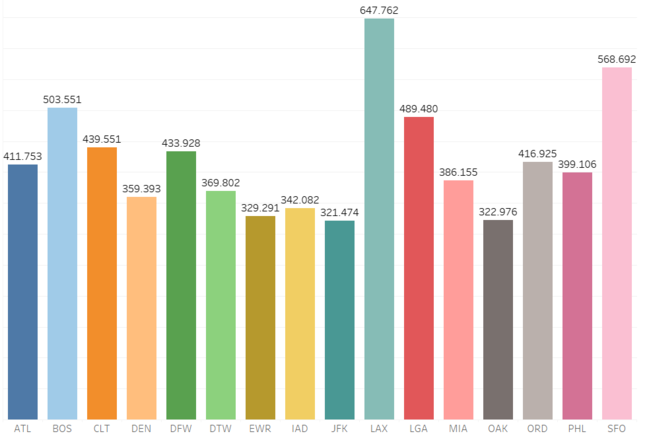

In [11]:
println("\nNumber of flights by month")
val flightsByMonth = rddDistinctFlights.
    map(x => (x._3, 1)).
    reduceByKey(_+_).
    collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Number of flights by month
flightsByMonth: Array[(String, Int)] = Array((04,205745), (05,768008), (06,1022075), (07,1080180), (08,1203901), (09,1192040), (10,880474), (11,389498))


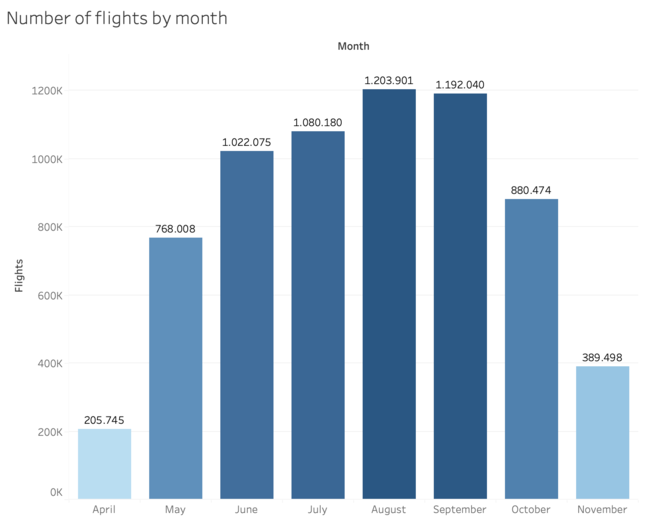

In [12]:
println("\nNumber of routes: " + rddDistinctFlights.map(x => (x._2, x._6)).distinct().count()) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


Number of routes: 235


| Query | Count |
| ----- | ----- | 
| Number of routes  | 235 |

In [25]:
println("Number of flights that offer an economy fare: " + rddFlights.
        filter(x => x.isEconomy).
        map(x => x.flightID).
        distinct().
        count())

println("Number of flights that offer a non economy fare: " + rddFlights.
        filter(x => !x.isEconomy).
        map(x => x.flightID).
        distinct().
        count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of flights that offer an economy fare: 1189124
Number of flights that offer a non economy fare: 5551777


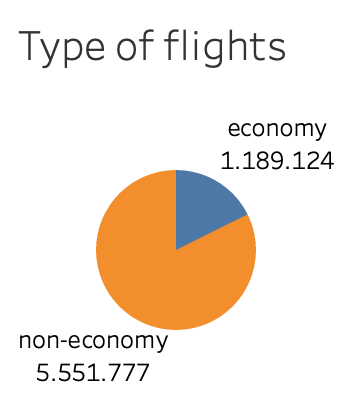

In [14]:
println("Number of direct flights: " + rddDistinctFlights.filter(x => x._4).count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of direct flights: 809106


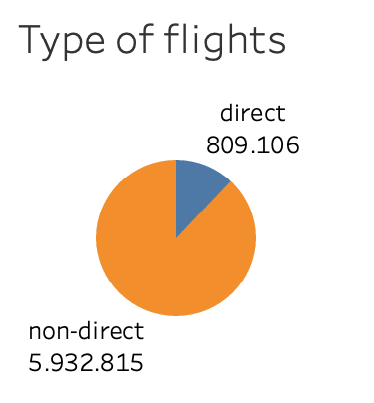

## Jobs

In [15]:
import org.apache.spark.sql.SaveMode

val output_path = "s3a://"+bucketname+"/spark/bdexam"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.sql.SaveMode
output_path: String = s3a://unibo-bd2223-vfolin/spark/bdexam


### 1 - Veronika Folin

The change that occurs in the ticket price in 30 days prior to flight departure is calculated, dividing the result between economy and no-economy tickets.

The correlation between that change in price and the number of seats remaining on that flight is then displayed.

In [16]:
/* Imports necessary to calculate the correlation matrix and the time spent executing the query*/

import org.apache.spark.mllib.stat.Statistics
import org.apache.spark.mllib.linalg._

import java.util.concurrent.TimeUnit


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.mllib.stat.Statistics
import org.apache.spark.mllib.linalg._
import java.util.concurrent.TimeUnit


In [17]:
/*
We filter data to obtain searches made in the last 30 days before flight departure.
The filtering operation allows us to reduce the number of records.
*/

val rddFlightsFiltered = rddFlights.
    filter(x => daysBetween(x) <= 30)

rddFlightsFiltered.persist(StorageLevel.MEMORY_AND_DISK)
//rddFlightsFiltered.persist(StorageLevel.DISK_ONLY) // to know the exact occupation of the dataset

"Number of filtered flights: " + rddFlightsFiltered.count() // 47674280

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rddFlightsFiltered: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[25] at filter at <console>:45
res30: rddFlightsFiltered.type = MapPartitionsRDD[25] at filter at <console>:45
res33: String = Number of filtered flights: 47674280


| RDD's name | Number of records | Size | Partitions 
| ----- | ----- | ----- | ----- | 
| rddFlightsFiltered | 47674280 | 6.3 GB | 927

In [18]:
/* We divide the result between economy and no-economy tickets */

val rddEconomyFlights = rddFlightsFiltered.filter(_.isEconomy)

rddEconomyFlights.persist(StorageLevel.MEMORY_AND_DISK)
//rddEconomyFlights.persist(StorageLevel.DISK_ONLY) // to know the exact occupation of the dataset

"Number of economy flights: " + rddEconomyFlights.count()


val rddNoEconomyFlights = rddFlightsFiltered.filter(!_.isEconomy)

rddNoEconomyFlights.persist(StorageLevel.MEMORY_AND_DISK)
//rddNoEconomyFlights.persist(StorageLevel.DISK_ONLY) // to know the exact occupation of the dataset

"Number of no-economy flights: " + rddNoEconomyFlights.count() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rddEconomyFlights: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[26] at filter at <console>:39
res37: rddEconomyFlights.type = MapPartitionsRDD[26] at filter at <console>:39
res40: String = Number of economy flights: 6356288
rddNoEconomyFlights: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[27] at filter at <console>:39
res44: rddNoEconomyFlights.type = MapPartitionsRDD[27] at filter at <console>:39
res47: String = Number of no-economy flights: 41317992


| RDD's name | Number of records | Size | Partitions 
| ----- | ----- | ----- | ----- | 
| rddEconomyFlights | 6356288 | 865.3 MB | 927
| rddNoEconomyFlights | 41317992 | 5.4 GB | 927

#### Not optimized version

In [ ]:
/* ECONOMY FLIGHTS */

val t0 = System.nanoTime()

/* We calculate the average ticket price in a given number of days before departure */
val rddAveragePriceEconomy = rddEconomyFlights.
    map(x => (daysBetween(x), x.baseFare)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

/*We calculate the average number of seats remaining on flights over a given number of days before departure*/
val rddAverageSeatsRemainingEconomy = rddEconomyFlights.
    map(x => (daysBetween(x), x.seatsRemaining)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

/* We join average ticket prices with average number of remaining seats*/ 
val rddEconomyResult = rddAverageSeatsRemainingEconomy.join(rddAveragePriceEconomy).
    map({case(k,v) => (k, v._1, v._2)})

/* Save the result on S3 to reuse it*/
rddEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

/*We calculate the correlation matrix between the attributes AverageSeatsRemaining and AveragePrice*/
val economyData = rddEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => Vectors.dense(averageSeatsRemaining, averagePrice)})
val correlMatrixEconomy: Matrix = Statistics.corr(economyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

/*

correlMatrixEconomy:
1.0                  -0.9055847376668811
-0.9055847376668811  1.0

Elapsed time: 47.7436543089891 seconds

*/

In [ ]:
/* NO-ECONOMY FLIGHTS*/

val t0 = System.nanoTime()

/* We calculate the average ticket price in a given number of days before departure */
val rddAveragePriceNoEconomy = rddNoEconomyFlights.
    map(x => (daysBetween(x), x.baseFare)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

/*We calculate the average number of seats remaining on flights over a given number of days before departure*/
val rddAverageSeatsRemainingNoEconomy = rddNoEconomyFlights.
    map(x => (daysBetween(x), x.seatsRemaining)).
    aggregateByKey((0.0,0.0))(
        (acc,value)=>(acc._1+value, acc._2 + 1), 
        (value1,value2)=>(value1._1 + value2._1, value1._2 + value2._2)).
    map({case(k,v) => (k, v._1/v._2)})

/* We join average ticket prices with average number of remaining seats*/ 
val rddNoEconomyResult = rddAverageSeatsRemainingNoEconomy.join(rddAveragePriceNoEconomy).
    map({case(k,v) => (k, v._1, v._2)})

/* Save the result on S3 to reuse it*/
rddNoEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

/*We calculate the correlation matrix between the attributes AverageSeatsRemaining and AveragePrice*/
val noEconomyData = rddNoEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
    Vectors.dense(averageSeatsRemaining, averagePrice)})
val correlMatrixNoEconomy: Matrix = Statistics.corr(noEconomyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

/*

correlMatrixEconomy:
1.0                  -0.7933229293346507
-0.7933229293346507  1.0

Elapsed time: 106.87263422193624 seconds

*/

#### Optimized version

In [ ]:
/* ECONOMY FLIGHT */

val t0 = System.nanoTime()

val zeroValue = (0, (0.0, 0.0))

val rddEconomyResult = rddEconomyFlights.
    map(x => (daysBetween(x), (x.seatsRemaining, x.baseFare))).
    aggregateByKey(zeroValue)(
            (tuple, prev) => {
                val count = tuple._1 + 1
                val seatsRemainingSum = tuple._2._1 + prev._1
                val baseFareSum = tuple._2._2 + prev._2
                (count, (seatsRemainingSum, baseFareSum))
            },
            (tuple1, tuple2) => {
                val count1 = tuple1._1 + tuple2._1
                val seatsRemainingSum1 = tuple1._2._1 + tuple2._2._1
                val baseFareSum1 = tuple1._2._2 + tuple2._2._2
                (count1, (seatsRemainingSum1, baseFareSum1))
            }
        ).
    map({case(k,(count2, (seatsRemainingSum2, baseFareSum2))) => (k, seatsRemainingSum2/count2, baseFareSum2/count2)})

rddEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val economyData = rddEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
     Vectors.dense(averageSeatsRemaining, averagePrice)})

val correlMatrixEconomy: Matrix = Statistics.corr(economyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

/*

correlMatrixEconomy:
1.0                  -0.9055847376670673
-0.9055847376670673  1.0

Elapsed time: 37.7554258834158 seconds

*/

In [ ]:
/* NO-ECONOMY FLIGHTS */

val t0 = System.nanoTime()

val zeroValue = (0, (0.0, 0.0))

val rddNoEconomyResult = rddNoEconomyFlights.
    map(x => (daysBetween(x), (x.seatsRemaining, x.baseFare))).
    aggregateByKey(zeroValue)(
            (tuple, prev) => {
                val count = tuple._1 + 1
                val seatsRemainingSum = tuple._2._1 + prev._1
                val baseFareSum = tuple._2._2 + prev._2
                (count, (seatsRemainingSum, baseFareSum))
            },
            (tuple1, tuple2) => {
                val count1 = tuple1._1 + tuple2._1
                val seatsRemainingSum1 = tuple1._2._1 + tuple2._2._1
                val baseFareSum1 = tuple1._2._2 + tuple2._2._2
                (count1, (seatsRemainingSum1, baseFareSum1))
            }
        ).
    map({case(k,(count2, (seatsRemainingSum2, baseFareSum2))) => (k, seatsRemainingSum2/count2, baseFareSum2/count2)})

rddNoEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val noEconomyData = rddNoEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
     Vectors.dense(averageSeatsRemaining, averagePrice)})

val correlMatrixNoEconomy: Matrix = Statistics.corr(noEconomyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

/*

correlMatrixEconomy:
1.0                  -0.7933229293345855
-0.7933229293345855  1.0

Elapsed time: 60.134621501376664 seconds

*/

#### Optimized version with repartitioning

In [39]:
/* ECONOMY FLIGHTS */

val rdd0 = rddFlightsFiltered.filter(_.isEconomy).coalesce(20) // 73.14933381141708 seconds

val rdd1 = rddFlightsFiltered.filter(_.isEconomy).coalesce(50) // 41.41846976682828 seconds

val rdd2 = rddFlightsFiltered.filter(_.isEconomy).coalesce(100) // 36.758913842573584 seconds

val rdd3 = rddFlightsFiltered.filter(_.isEconomy).coalesce(300) // 39.25749231514362 seconds

val rdd4 = rddFlightsFiltered.filter(_.isEconomy).coalesce(500) // 35.373311204075044 seconds

val rdd5 = rddFlightsFiltered.filter(_.isEconomy).coalesce(700) // 34.80990272713086 seconds


val rdd6 = rddFlightsFiltered.filter(_.isEconomy).repartition(20) // 43.058554013857204 seconds

val rdd7 = rddFlightsFiltered.filter(_.isEconomy).repartition(50) // 44.388037692999 seconds

val rdd8 = rddFlightsFiltered.filter(_.isEconomy).repartition(100) // 46.44641517772536 seconds

val rdd9 = rddFlightsFiltered.filter(_.isEconomy).repartition(300) // 76.73079507920988 seconds

val rdd10 = rddFlightsFiltered.filter(_.isEconomy).repartition(500) // 73.88318846521662 seconds

val rdd11 = rddFlightsFiltered.filter(_.isEconomy).repartition(700) // 85.76706534800083 seconds

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rdd0: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[415] at coalesce at <console>:40
rdd1: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[417] at coalesce at <console>:38
rdd2: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[419] at coalesce at <console>:38
rdd3: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[421] at coalesce at <console>:38
rdd4: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[423] at coalesce at <console>:38
rdd5: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[425] at coalesce at <console>:38
rdd6: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[430] at repartition at <console>:39
rdd7: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[435] at repartition at <console>:38
rdd8: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[440] at repartition at <console>:38
rdd9: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[445] at repartition at <console>:38
rdd10: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD

In [45]:
/* ECONOMY FLIGHTS */

val t0 = System.nanoTime()

val zeroValue = (0, (0.0, 0.0))

val rddEconomyResult = rdd11.
    map(x => (daysBetween(x), (x.seatsRemaining, x.baseFare))).
    coalesce(20).
    aggregateByKey(zeroValue)(
            (tuple, prev) => {
                val count = tuple._1 + 1
                val seatsRemainingSum = tuple._2._1 + prev._1
                val baseFareSum = tuple._2._2 + prev._2
                (count, (seatsRemainingSum, baseFareSum))
            },
            (tuple1, tuple2) => {
                val count1 = tuple1._1 + tuple2._1
                val seatsRemainingSum1 = tuple1._2._1 + tuple2._2._1
                val baseFareSum1 = tuple1._2._2 + tuple2._2._2
                (count1, (seatsRemainingSum1, baseFareSum1))
            }
        ).
    map({case(k,(count2, (seatsRemainingSum2, baseFareSum2))) => (k, seatsRemainingSum2/count2, baseFareSum2/count2)})

rddEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val economyData = rddEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
     Vectors.dense(averageSeatsRemaining, averagePrice)})

val correlMatrixEconomy: Matrix = Statistics.corr(economyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t0: Long = 9872990806542
zeroValue: (Int, (Double, Double)) = (0,(0.0,0.0))
rddEconomyResult: org.apache.spark.rdd.RDD[(Long, Double, Double)] = MapPartitionsRDD[549] at map at <console>:59
economyData: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[555] at map at <console>:38
correlMatrixEconomy: org.apache.spark.mllib.linalg.Matrix =
1.0                  -0.9055847376651353
-0.9055847376651353  1.0
t1: Long = 9958756156583
Elapsed time: 85.76706534800083 seconds


##### Time taken by the query in the various tests (economy flights version)

Elapsed time with no repartitioning: 37.7554258834158 seconds

| Function | Partitions | Time in seconds
| ----- | ----- | ----- | 
| coalesce | 20 | 73.14933381141708
| coalesce | 50 | 41.41846976682828
| coalesce | 100 | 36.758913842573584
| coalesce | 300 | 39.25749231514362
| coalesce | 500 | 35.373311204075044
| coalesce | 700 | 34.80990272713086
| repartition | 20 | 43.058554013857204
| repartition | 50 | 44.388037692999
| repartition | 100 | 46.44641517772536
| repartition | 300 | 76.73079507920988
| repartition | 500 | 73.88318846521662
| repartition | 700 | 85.76706534800083

In [60]:
/* NO-ECONOMY FLIGHT */

val rdd12 = rddFlightsFiltered.filter(!_.isEconomy).coalesce(20) // 43.89774381631758 seconds

val rdd13 = rddFlightsFiltered.filter(!_.isEconomy).coalesce(50) // 39.83028050067822 seconds

val rdd14 = rddFlightsFiltered.filter(!_.isEconomy).coalesce(100) // 39.29833457997258 seconds

val rdd15 = rddFlightsFiltered.filter(!_.isEconomy).coalesce(300) // 39.59028868193784 seconds

val rdd16 = rddFlightsFiltered.filter(!_.isEconomy).coalesce(500) // 39.6152228736117 seconds

val rdd17 = rddFlightsFiltered.filter(!_.isEconomy).coalesce(700) // 40.72203086232876 seconds


val rdd18 = rddFlightsFiltered.filter(!_.isEconomy).repartition(20) // 98.84676594278095 seconds

val rdd19 = rddFlightsFiltered.filter(!_.isEconomy).repartition(50) // 100.79795889285948 seconds

val rdd20 = rddFlightsFiltered.filter(!_.isEconomy).repartition(100) // 109.06771449766374 seconds

val rdd21 = rddFlightsFiltered.filter(!_.isEconomy).repartition(300) // 214.71357142954488 seconds

val rdd22 = rddFlightsFiltered.filter(!_.isEconomy).repartition(500) // 220.35858552256877 seconds

val rdd23 = rddFlightsFiltered.filter(!_.isEconomy).repartition(700) // 221.25600689263723 seconds

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rdd12: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[794] at coalesce at <console>:39
rdd13: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[796] at coalesce at <console>:38
rdd14: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[798] at coalesce at <console>:38
rdd15: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[800] at coalesce at <console>:38
rdd16: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[802] at coalesce at <console>:38
rdd17: org.apache.spark.rdd.RDD[FlightData] = CoalescedRDD[804] at coalesce at <console>:38
rdd18: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[809] at repartition at <console>:39
rdd19: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[814] at repartition at <console>:38
rdd20: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[819] at repartition at <console>:38
rdd21: org.apache.spark.rdd.RDD[FlightData] = MapPartitionsRDD[824] at repartition at <console>:38
rdd22: org.apache.spark.rdd.RDD[FlightData] = MapPar

In [61]:
/* NO-ECONOMY FLIGHTS */

val t0 = System.nanoTime()

val zeroValue = (0, (0.0, 0.0))

val rddNoEconomyResult = rdd23.
    map(x => (daysBetween(x), (x.seatsRemaining, x.baseFare))).
    aggregateByKey(zeroValue)(
            (tuple, prev) => {
                val count = tuple._1 + 1
                val seatsRemainingSum = tuple._2._1 + prev._1
                val baseFareSum = tuple._2._2 + prev._2
                (count, (seatsRemainingSum, baseFareSum))
            },
            (tuple1, tuple2) => {
                val count1 = tuple1._1 + tuple2._1
                val seatsRemainingSum1 = tuple1._2._1 + tuple2._2._1
                val baseFareSum1 = tuple1._2._2 + tuple2._2._2
                (count1, (seatsRemainingSum1, baseFareSum1))
            }
        ).
    map({case(k,(count2, (seatsRemainingSum2, baseFareSum2))) => (k, seatsRemainingSum2/count2, baseFareSum2/count2)})

rddNoEconomyResult.coalesce(1).toDF().write.format("csv").mode(SaveMode.Overwrite).save(output_path)

val noEconomyData = rddNoEconomyResult.map({case(days,averageSeatsRemaining, averagePrice) => 
     Vectors.dense(averageSeatsRemaining, averagePrice)})

val correlMatrixNoEconomy: Matrix = Statistics.corr(noEconomyData)

val t1 = System.nanoTime()
println("Elapsed time: " + ((t1 - t0) * 1.00002e-9)  + " seconds")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t0: Long = 11300697052468
zeroValue: (Int, (Double, Double)) = (0,(0.0,0.0))
rddNoEconomyResult: org.apache.spark.rdd.RDD[(Long, Double, Double)] = MapPartitionsRDD[837] at map at <console>:58
noEconomyData: org.apache.spark.rdd.RDD[org.apache.spark.mllib.linalg.Vector] = MapPartitionsRDD[843] at map at <console>:38
correlMatrixNoEconomy: org.apache.spark.mllib.linalg.Matrix =
1.0                  -0.7933229293345437
-0.7933229293345437  1.0
t1: Long = 11521948634329
Elapsed time: 221.25600689263723 seconds


##### Time taken by the query in the various tests (no-economy flights version)

Elapsed time with no repartitioning: 60.134621501376664 seconds

| Function | Partitions | Time in seconds
| ----- | ----- | ----- | 
| coalesce | 20 | 43.89774381631758
| coalesce | 50 | 39.83028050067822
| coalesce | 100 | 39.29833457997258
| coalesce | 300 | 39.59028868193784
| coalesce | 500 | 39.6152228736117
| coalesce | 700 | 40.72203086232876
| repartition | 20 | 98.84676594278095
| repartition | 50 | 100.79795889285948
| repartition | 100 | 109.06771449766374
| repartition | 300 | 214.71357142954488
| repartition | 500 | 220.35858552256877
| repartition | 700 | 221.25600689263723